Main question: Does a team being the manufacturer of their engine affect
performance (#wins, #points)?

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [158]:
engine_manufacturers  = pd.read_csv('dataset/engine_manufacturers_processed.csv')
races                 = pd.read_csv('dataset/races.csv')
constructors          = pd.read_csv('dataset/constructors.csv')
constructor_standings = pd.read_csv('dataset/constructor_standings.csv')
engine_manufacturers  = pd.read_csv('dataset/engine_manufacturers_processed.csv')

In [159]:
# Before we get to the good stuff, we need to do a little data wrangling so we can see the results of 
# each constructor at the end of the year.
# Our data is separated like an SQL database, so we'll have to use a few joins/merges.

# We have engine manufacturer data between 2010-2020, so we need to filter races
# so they fall in the same timeframe.
races = races[(2010 <= races['year']) & (races['year'] <= 2020)]
races = races[['raceId', 'year']]   # Only need these two columns.
# display(races[races['year'] == 2010])


In [160]:
# Note that there are some teams that changed their names in the 2010-2020 period, so we must account for that.
# Note that thte original dataset calls the team 'Alpha Tauri' 'AlphaTauri', so we need to account for that in the name change too.

def replace_constructor_by_name(df, original_names: list, new_name: str):
    df[df['name'].isin(original_names)] = df[df['name'] == new_name] 

def replace_constructor_by_id(df, original_names: list, new_name: str):
    df[df['constructorId'].isin(original_names)] = df[df['constructorId'] == new_name] 

replace_constructor_by_name(constructors, ['Force India'], 'Racing Point')
replace_constructor_by_name(constructors, ['Toro Rosso'], 'AlphaTauri')
replace_constructor_by_name(constructors, ['Sauber'], 'Alfa Romeo')
replace_constructor_by_name(constructors, ['Lotus', 'Lotus F1'], 'Renault')
replace_constructor_by_name(constructors, ['Virgin', 'Marussia'], 'Manor Marussia')

replace_constructor_by_id(constructor_standings, [10], 211)
replace_constructor_by_id(constructor_standings, [5], 213)
replace_constructor_by_id(constructor_standings, [15], 51)
replace_constructor_by_id(constructor_standings, [205, 208], 4)
replace_constructor_by_id(constructor_standings, [166, 206], 209)

In [161]:

constructor_standings_by_race = pd.merge(races, constructor_standings[['constructorId', 'raceId', 'points', 'wins']], on=['raceId'], how='left')
# display(constructor_standings_by_race[constructor_standings_by_race['raceId'] == 337])

constructor_standings_by_race = pd.merge(constructor_standings_by_race, engine_manufacturers, on=['year', 'constructorId'], how='left')
# display(constructor_standings_by_race[constructor_standings_by_race['raceId'] == 337])

constructor_standings_by_race = pd.merge(constructor_standings_by_race, constructors[['constructorId', 'name']], on=['constructorId'], how='left')

# This should display the raceId, year, constructorId, points,
# engine_manufacturer, name (of the team) for just one race in one year.
display(constructor_standings_by_race[constructor_standings_by_race['raceId'] == 337])

,raceId,year,constructorId,points,wins,Unnamed: 0,engine_manufacturer,name
0,337,2010,6.0,43.0,1.0,3,Ferrari,Ferrari
1,337,2010,1.0,21.0,0.0,0,Mercedes,McLaren
2,337,2010,9.0,16.0,0.0,2,Renault,Red Bull
3,337,2010,131.0,18.0,0.0,1,Mercedes,Mercedes
4,337,2010,3.0,1.0,0.0,4,Cosworth,Williams
5,337,2010,4.0,0.0,0.0,5,Renault,Renault
6,337,2010,4.0,0.0,0.0,8,Cosworth,Renault
7,337,2010,164.0,0.0,0.0,9,Cosworth,HRT


In [162]:
display(constructor_standings_by_race)
constructor_standings_by_race['name'] = constructor_standings_by_race['name'].replace(old_to_new_names)

# Notice how 'Force India' becomes 'Racing Point' in the fifth row in 2010.
display(constructor_standings_by_race)

,raceId,year,constructorId,points,wins,Unnamed: 0,engine_manufacturer,name
0,337,2010,6.0,43.0,1.0,3,Ferrari,Ferrari
1,337,2010,1.0,21.0,0.0,0,Mercedes,McLaren
2,337,2010,9.0,16.0,0.0,2,Renault,Red Bull
3,337,2010,131.0,18.0,0.0,1,Mercedes,Mercedes
4,337,2010,3.0,1.0,0.0,4,Cosworth,Williams
...,...,...,...,...,...,...,...,...
1592,1047,2020,4.0,181.0,0.0,113,Renault,Renault
1593,1047,2020,51.0,8.0,0.0,116,Ferrari,Alfa Romeo
1594,1047,2020,3.0,0.0,0.0,118,Mercedes,Williams
1595,1047,2020,9.0,319.0,2.0,111,Honda,Red Bull


,raceId,year,constructorId,points,wins,Unnamed: 0,engine_manufacturer,name
0,337,2010,6.0,43.0,1.0,3,Ferrari,Ferrari
1,337,2010,1.0,21.0,0.0,0,Mercedes,McLaren
2,337,2010,9.0,16.0,0.0,2,Renault,Red Bull
3,337,2010,131.0,18.0,0.0,1,Mercedes,Mercedes
4,337,2010,3.0,1.0,0.0,4,Cosworth,Williams
...,...,...,...,...,...,...,...,...
1592,1047,2020,4.0,181.0,0.0,113,Renault,Renault
1593,1047,2020,51.0,8.0,0.0,116,Ferrari,Alfa Romeo
1594,1047,2020,3.0,0.0,0.0,118,Mercedes,Williams
1595,1047,2020,9.0,319.0,2.0,111,Honda,Red Bull


In [163]:
def linear_regression(df: pd.DataFrame, column: str):
    x = np.array(df['engine_manufacturer'])
    y = df[column]

    # Encode the categorical variable using OneHotEncoder
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(x.reshape(-1,1))

    # Fit a linear regression model to the data
    model = LinearRegression()
    model.fit(X_encoded, y)

    # Can also do `encoder.get_feature_names_out()` instead of the unique thing.
    print(f"Linear regression results for 'engine_manufacturer' vs '{column}'")
    print(pd.DataFrame({'Engine Manufacturer': np.unique(x), 'Coefficient': model.coef_}))

Linear regression results for 'engine_manufacturer' vs 'points'
  Engine Manufacturer  Coefficient
0            Cosworth   -81.716182
1             Ferrari    28.708740
2               Honda   -20.859853
3            Mercedes    66.985355
4             Renault     6.881940
Linear regression results for 'engine_manufacturer' vs 'wins'
  Engine Manufacturer  Coefficient
0            Cosworth    -0.986926
1             Ferrari    -0.089352
2               Honda    -0.552144
3            Mercedes     1.562286
4             Renault     0.066135


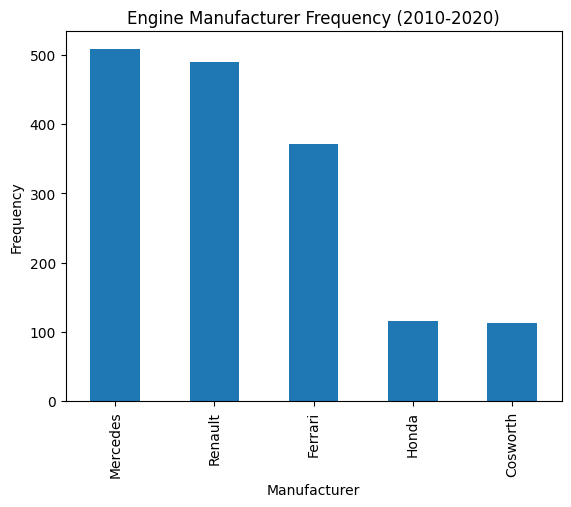

In [164]:
# Let's see how many times a manufacturer supplied to a team

ax = constructor_standings_by_race['engine_manufacturer'].value_counts().plot.bar()
ax.set_title('Engine Manufacturer Frequency (2010-2020)')
ax.set_xlabel('Manufacturer')
ax.set_ylabel('Frequency')


linear_regression(constructor_standings_by_race, 'points')
linear_regression(constructor_standings_by_race, 'wins')


The magnitude and sign of each coefficient indicates that a team achieves more or
fewer points/wins on average relative to the others.  

##### Points
For example: for Mercedes, it's the team that achieves the most points on
average. While Cosworth usually scores the least points.

On average, the three engine manufacturers that supply their own teams engines
(Mercedes, Ferrari, and Renault) are the most likely to score more points as
indicated by the magnitudes and signs of their coefficients.

##### Wins
The same trend follows for wins.

In [165]:
# Since the points field from `constructor_standings` accumulates over the races
# in a year, we can get the points at the last race to get the total points a
# team got in a year.
grouped = constructor_standings_by_race.groupby(['year', 'name', 'engine_manufacturer']).max(['name'])
df: pd.DataFrame = grouped.reset_index()

In [166]:
# Now, let's filter out a list of all teams that manufacture their own engines (team name == engine manufacturer name).
matches: pd.Series = df.groupby('name').apply(lambda x: (x['name'] == x['engine_manufacturer']).sum())
display(matches)

# Only a few teams actually manufacture their own engines consistently, let's filter them out.
self_manufacturing_teams = list(matches[matches > 1].keys())

print(f"Teams that make their own engines: {self_manufacturing_teams}")

name
Alfa Romeo         0
AlphaTauri         0
Caterham           0
Ferrari           11
HRT                0
Haas F1 Team       0
Manor Marussia     0
McLaren            0
Mercedes          11
Racing Point       0
Red Bull           0
Renault            7
Williams           0
dtype: int64

Teams that make their own engines: ['Ferrari', 'Mercedes', 'Renault']


In [167]:
# WARNING: LONG OUTPUT
# for name in df['name'].unique():
#     display(df[df['name'] == name][['year', 'name', 'engine_manufacturer', 'wins', 'points']])

In [168]:
# Then we plot the points or wins of all teams, the ones making their own engines are solid, everyone else is dashed.
def plot_by_year(dataframe, y_axis_data_name, y_axis_plot_name, title):
    fig,ax = plt.subplots()
    fig.set_dpi(200)
    fig.set_size_inches(10, 5)

    for name in dataframe['name'].unique():
        ax.plot(
            dataframe[dataframe.name==name].year,
            dataframe[dataframe.name==name][y_axis_data_name],
            label=name, 
            linestyle='dashed' if name not in self_manufacturing_teams else 'solid'
        )

    ax.hlines(dataframe[y_axis_data_name].mean(), dataframe['year'].min(), dataframe['year'].max(), linestyles='dotted', label='Mean')

    ax.set_xlabel("Year")
    ax.set_ylabel(y_axis_plot_name)
    ax.legend(loc='best')
    plt.title(title)

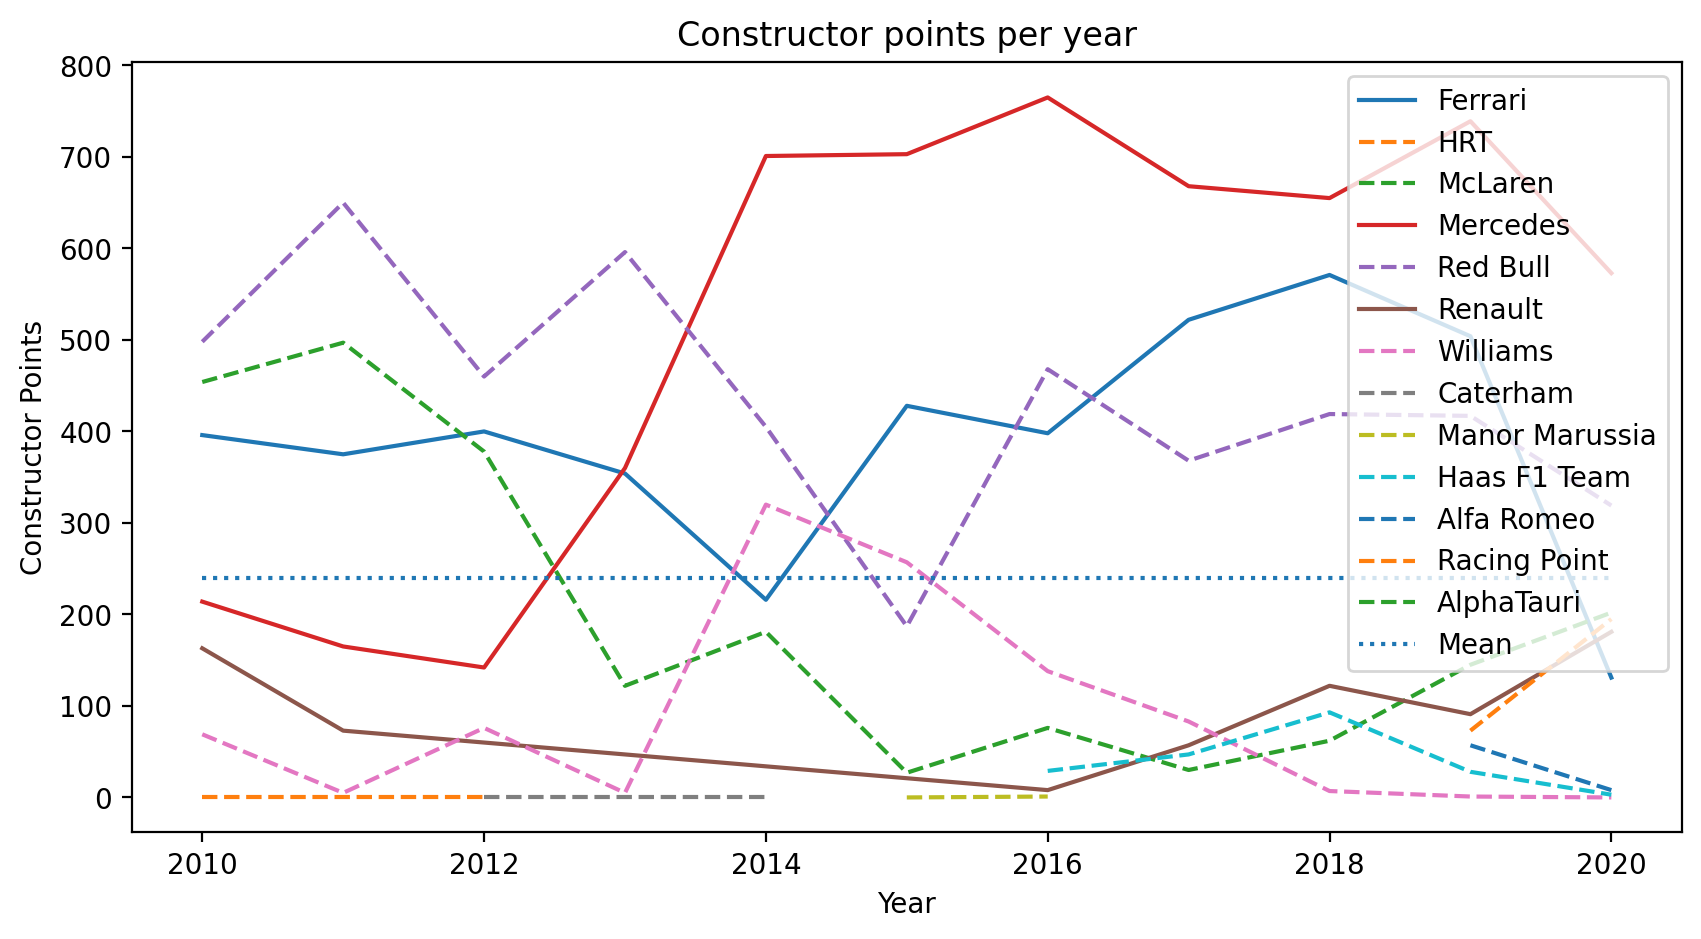

In [169]:
# Some teams can't be seen properly on the points graph due to their low scores.
# These teams are: HRT, Virgin, Caterham, Manor Marussiaa.
# teams_to_drop = ['HRT', 'Virgin', 'Caterham', 'Manor Marussia']
points = df # df[~df['name'].isin(teams_to_drop)]


plot_by_year(points, 'points', 'Constructor Points', 'Constructor points per year')

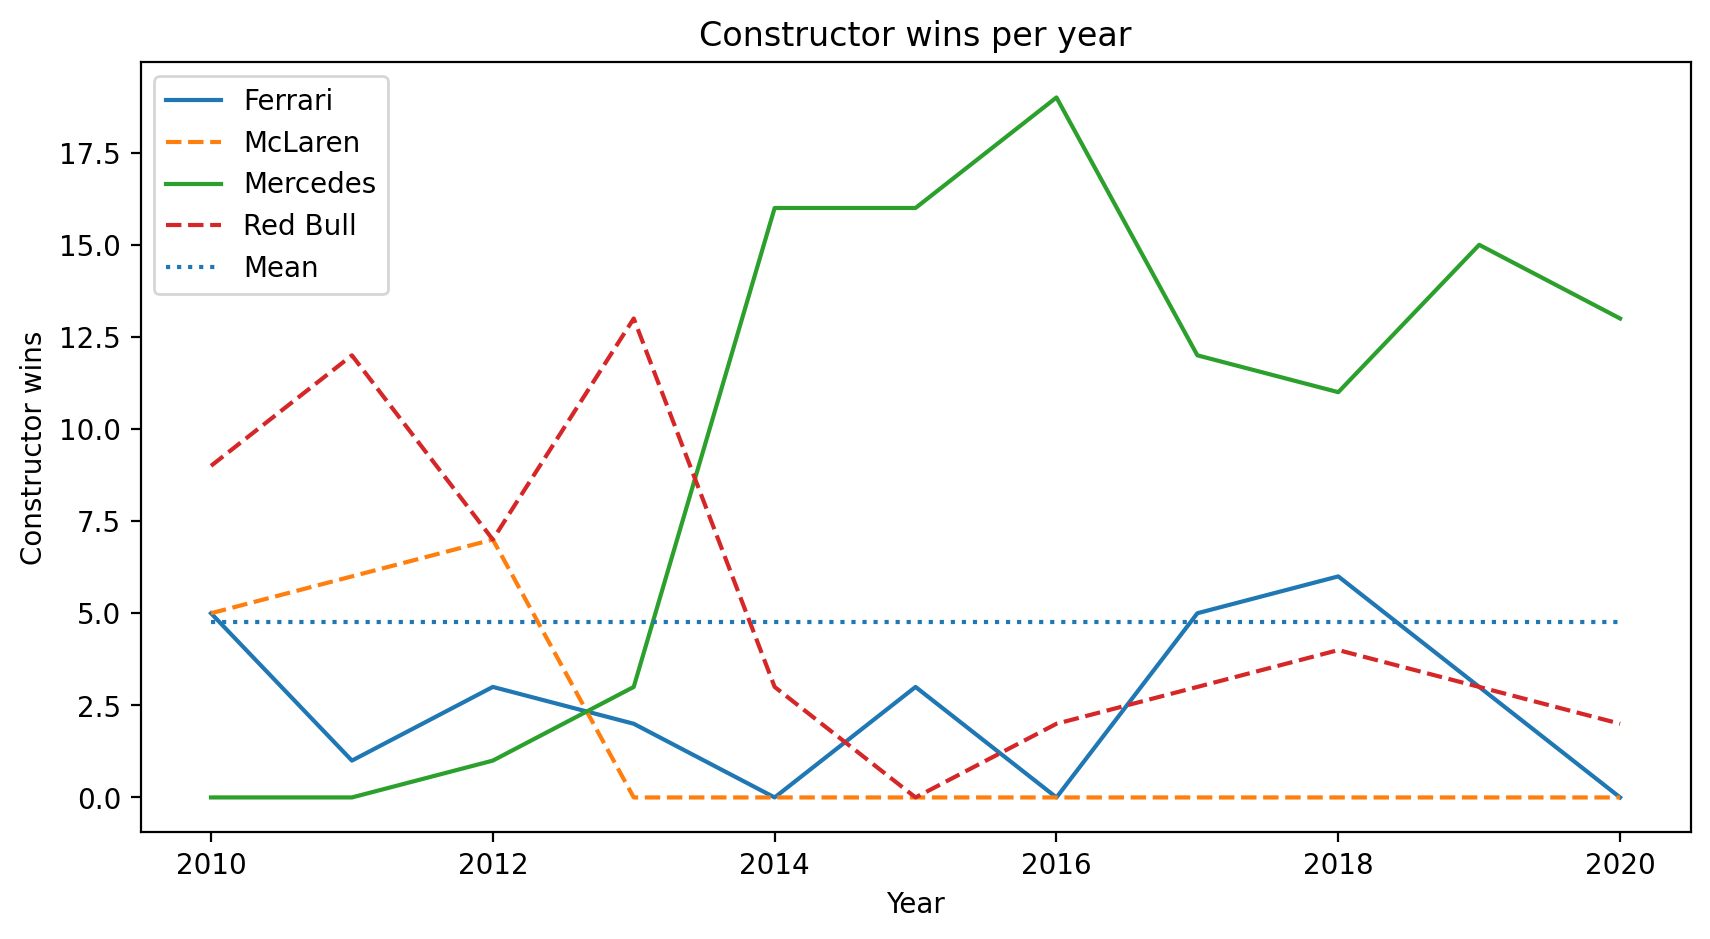

In [170]:

# Most teams have no wins and form a straight line at zero, we can also remove those for plotting.
# These teams are: Alfa Romeo, AlphaTauri, Renault, Haas F1 Team.
teams_to_drop = ['Alfa Romeo', 'AlphaTauri', 'Renault', 'Haas F1 Team', 'Williams', 'Racing Point', 'AlphaTauri', 'Manor Marussia', 'Caterham', 'HRT']
wins = df[~df['name'].isin(teams_to_drop)]

plot_by_year(wins, 'wins', 'Constructor wins', 'Constructor wins per year')

In [171]:
def logistic_regression(df: pd.DataFrame, col_name: str):
    # Create a binary feature indicating whether the team manufactures its own engine
    df['own_engine'] = (df['name'] == df['engine_manufacturer']).astype(int)
    column_mean = df[col_name].mean()

    # Select the relevant columns for the logistic regression model
    x = df[['own_engine']]
    y = (df[col_name] > column_mean).astype(int)

    # Fit a logistic regression model to the data
    model = LogisticRegression()
    model.fit(x, y)

    # Print the coefficients of the logistic regression model
    print('Logistic regression coefficients:', model.coef_)
    # print(model.intercept_)

logistic_regression(df, 'points')
logistic_regression(df, 'wins')

Logistic regression coefficients: [[1.01509934]]
Logistic regression coefficients: [[0.9970607]]


In the previous few cells, we plotted points and wins for all teams while marking teams that make their own engines (Mercedes, Ferrari, Renault).

The plots show that 2 of the 3 teams that make their own engines usually score above the mean points value. And for wins, this follows albeit to a lesser degree.

By applying logsitic regression, we can see from the value of the coefficients that making your own engine positively increases your chances of scoring points or wins > the mean.